#URBAN SOUNDS CLASSIFICATION

##Model File

In this study, our group probably following a different path than other groups with did not proceed by fine-tuning an existing model available on Github. Instead of consuming the processing power of our already inadequate hardware, we have turned to learning cloud-based services and solutions suitable for the needs of the industry. For that purpose, we used Amazon AWS ML services for model training. 



## **Traininig with Unconverted RGB Images**

First of all, we uploaded the unconverted images on S3 Bucket and analyzed them on Rekognition. You can see the results below.

After the dataset is labeled, it is divided into 80% train and 20% test.
You can see the number of test sets used for each classification, F1 score, Precision and Recall Values, and assumed threshold values ​​below.

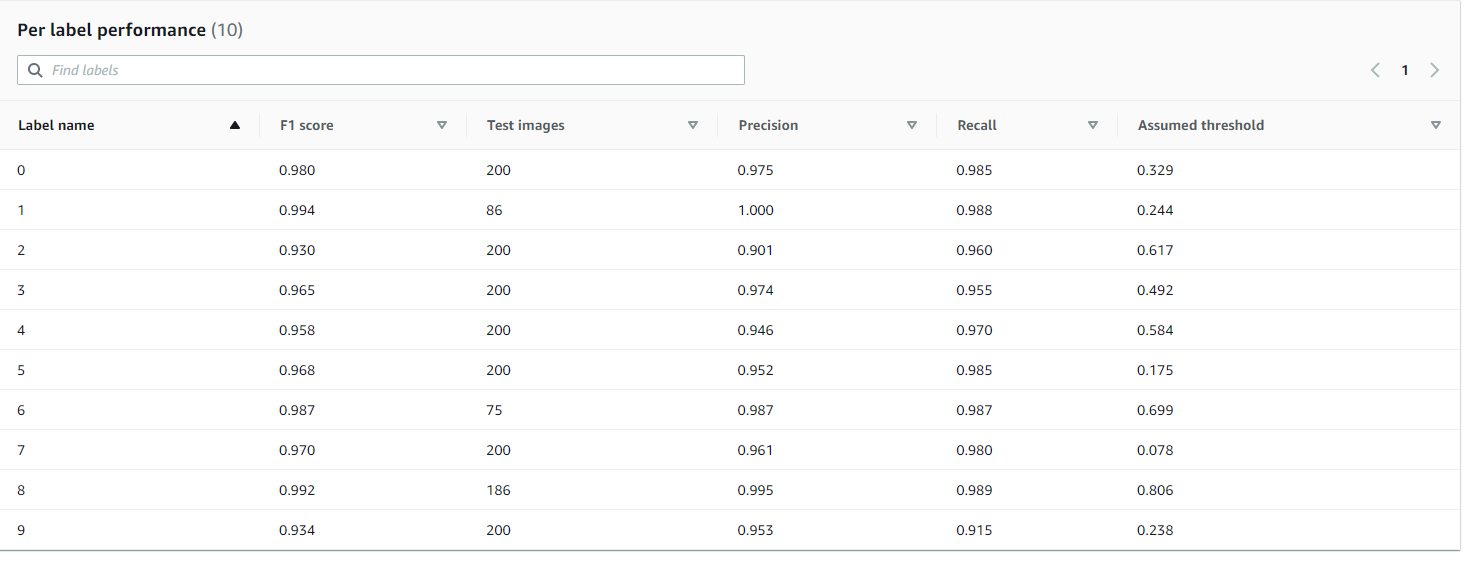

Our Training set includes 6985 images and our test set includes 1747 images.
* F1 Score of our evaluation is 0.968
* Average precision of our evalution is 0.964
* And our overall Recall value is 0.971 
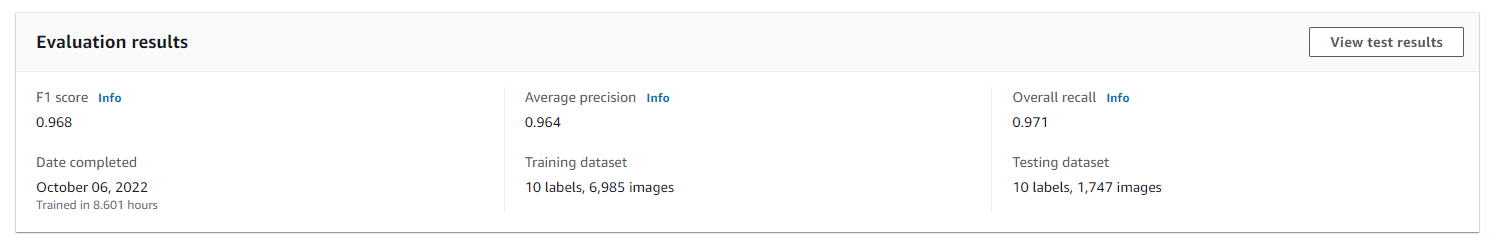

The True Positive image number of our Test set is 1693 
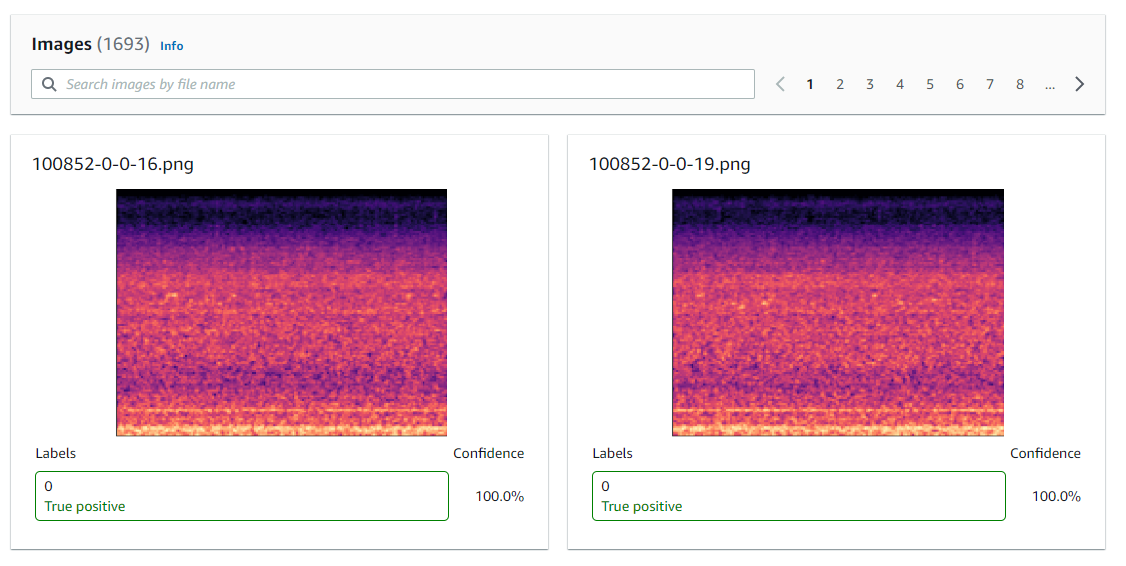

* The False Positive image number of our model is only **70** images
* Also there is **0 False negative image** in our model

 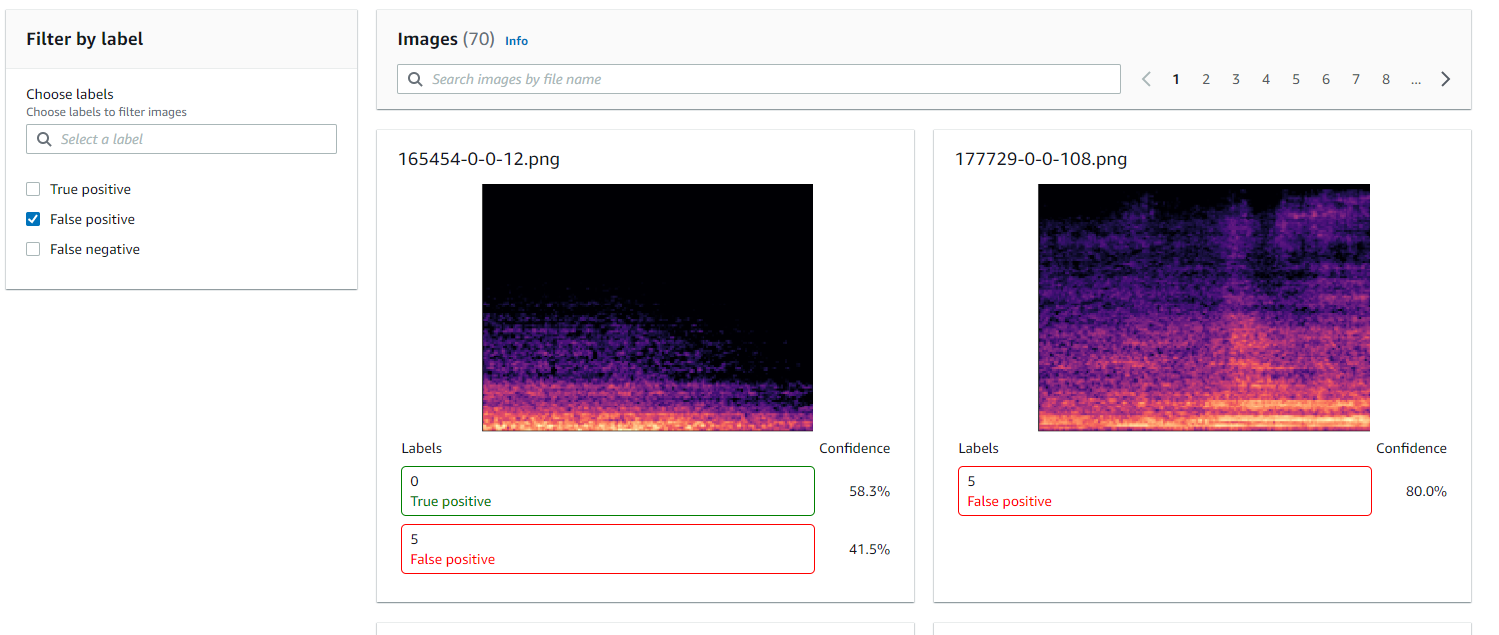

Our validation results are also added as json files under Github Page.
* Manifest_summary
* Testing_manifest_with_validation
* Training_manifest_with_validation

In [ ]:
from os import stat_result
import boto3
import argparse
import logging
import time
import json
from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)

def train_model(rek_client, project_arn, version_name, output_bucket, output_folder, tag_key, tag_key_value):
    """
    Trains an Amazon Rekognition Custom Labels model.
    :param rek_client: The Amazon Rekognition Custom Labels Boto3 client.
    :param project_arn: The ARN of the project in which you want to train a model.
    :param version_name: A version for the model.
    :param output_bucket: The S3 bucket that hosts training output.
    :param output_folder: The path for the training output within output_bucket
    :param tag_key: The name of a tag to attach to the model. Pass None to exclude
    :param tag_key_value: The value of the tag. Pass None to exclude

    """

    try:
        #Train the model

        status="" 
        logger.info(f"training model version {version_name} for project {project_arn}")


        output_config = json.loads(
            '{"S3Bucket": "'
            + output_bucket
            + '", "S3KeyPrefix": "'
            + output_folder
            + '" }  '
        )

        tags={}

        if tag_key!=None and tag_key_value !=None:
            tags = json.loads(
                '{"' + tag_key + '":"' + tag_key_value + '"}'
            )


        response=rek_client.create_project_version(
            ProjectArn=project_arn, 
            VersionName=version_name,
            OutputConfig=output_config,
            Tags=tags
        )

        logger.info(f"Started training: {response['ProjectVersionArn']}")

        # Wait for the project version training to complete

        project_version_training_completed_waiter = rek_client.get_waiter('project_version_training_completed')
        project_version_training_completed_waiter.wait(ProjectArn=project_arn,
        VersionNames=[version_name])
    

        #Get the completion status
        describe_response=rek_client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            logger.info("Status: " + model['Status'])
            logger.info("Message: " + model['StatusMessage']) 
            status=model['Status']


        logger.info(f"finished training")

        return response['ProjectVersionArn'], status
    
    except ClientError as err:  
        logger.exception(f"Couldn't create model: {err.response['Error']['Message']}")
        raise

def add_arguments(parser):
    """
    Adds command line arguments to the parser.
    :param parser: The command line parser.
    """

    parser.add_argument(
        "project_arn", help="The ARN of the project in which you want to train a model"
    )

    parser.add_argument(
        "version_name", help="A version name of your choosing."
    )

    parser.add_argument(
        "output_bucket", help="The S3 bucket that receives the training results."
    )

    parser.add_argument(
        "output_folder", help="The folder in the S3 bucket where training results are stored."
    )

    parser.add_argument(
        "--tag_name",  help="The name of a tag to attach to the model", required=False
    )

    parser.add_argument(
        "--tag_value",  help="The value for the tag.", required=False
    )




def main():

    logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

    try:

        #get command line arguments
        parser = argparse.ArgumentParser(usage=argparse.SUPPRESS)
        add_arguments(parser)
        args = parser.parse_args()

        print(f"Training model version {args.version_name} for project {args.project_arn}")

        #Train the model
        rek_client=boto3.client('rekognition')

        model_arn, status=train_model(rek_client, 
            args.project_arn,
            args.version_name,
            args.output_bucket,
            args.output_folder,
            args.tag_name,
            args.tag_value)


        print(f"Finished training model: {model_arn}")
        print(f"Status: {status}")


    except ClientError as err:
        logger.exception(f"Problem training model: {err}")
        print(f"Problem training model: {err}")
    except Exception as err:
        logger.exception(f"Problem training model: {err}")
        print(f"Problem training model: {err}")


if __name__ == "__main__":
    main()    
  

## **Converted Gray Scale Images Results in below**

Our Training set includes 6985 images and our test set includes 1747 images.
* F1 Score of our evaluation is 0.965
* Average precision of our evalution is 0.973
* And our overall Recall value is 0.957
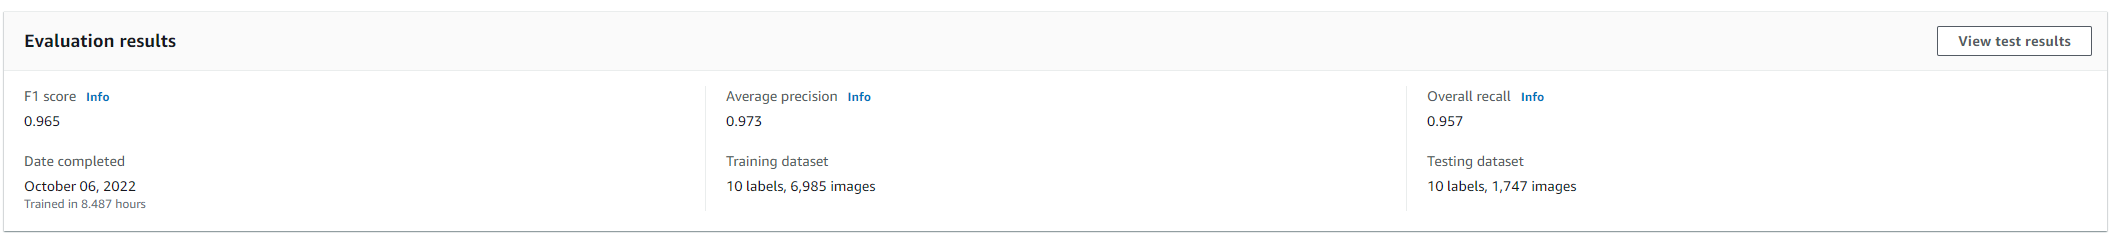

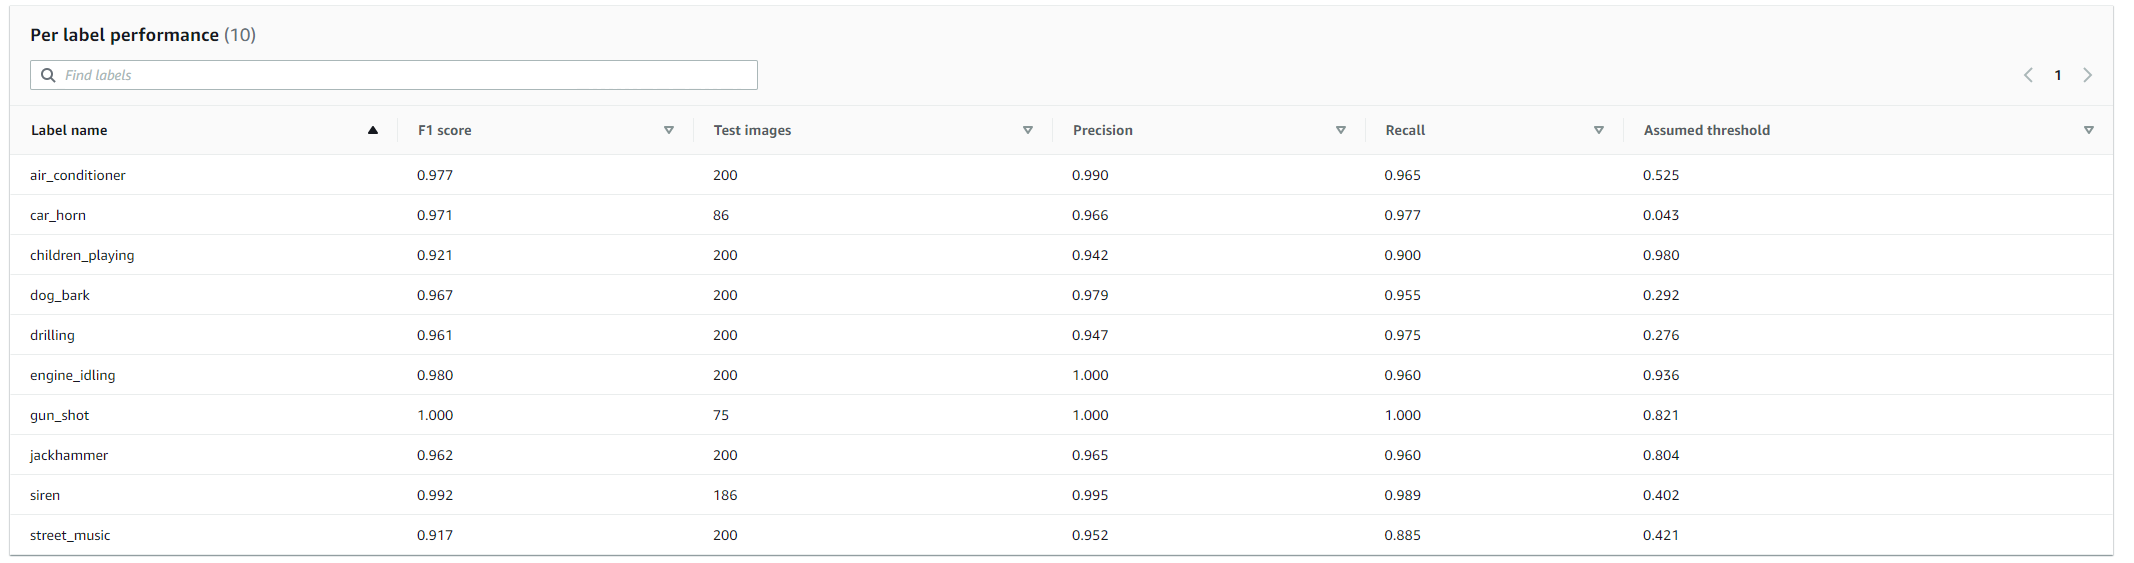

The True Positive image number of our Test set is 1663
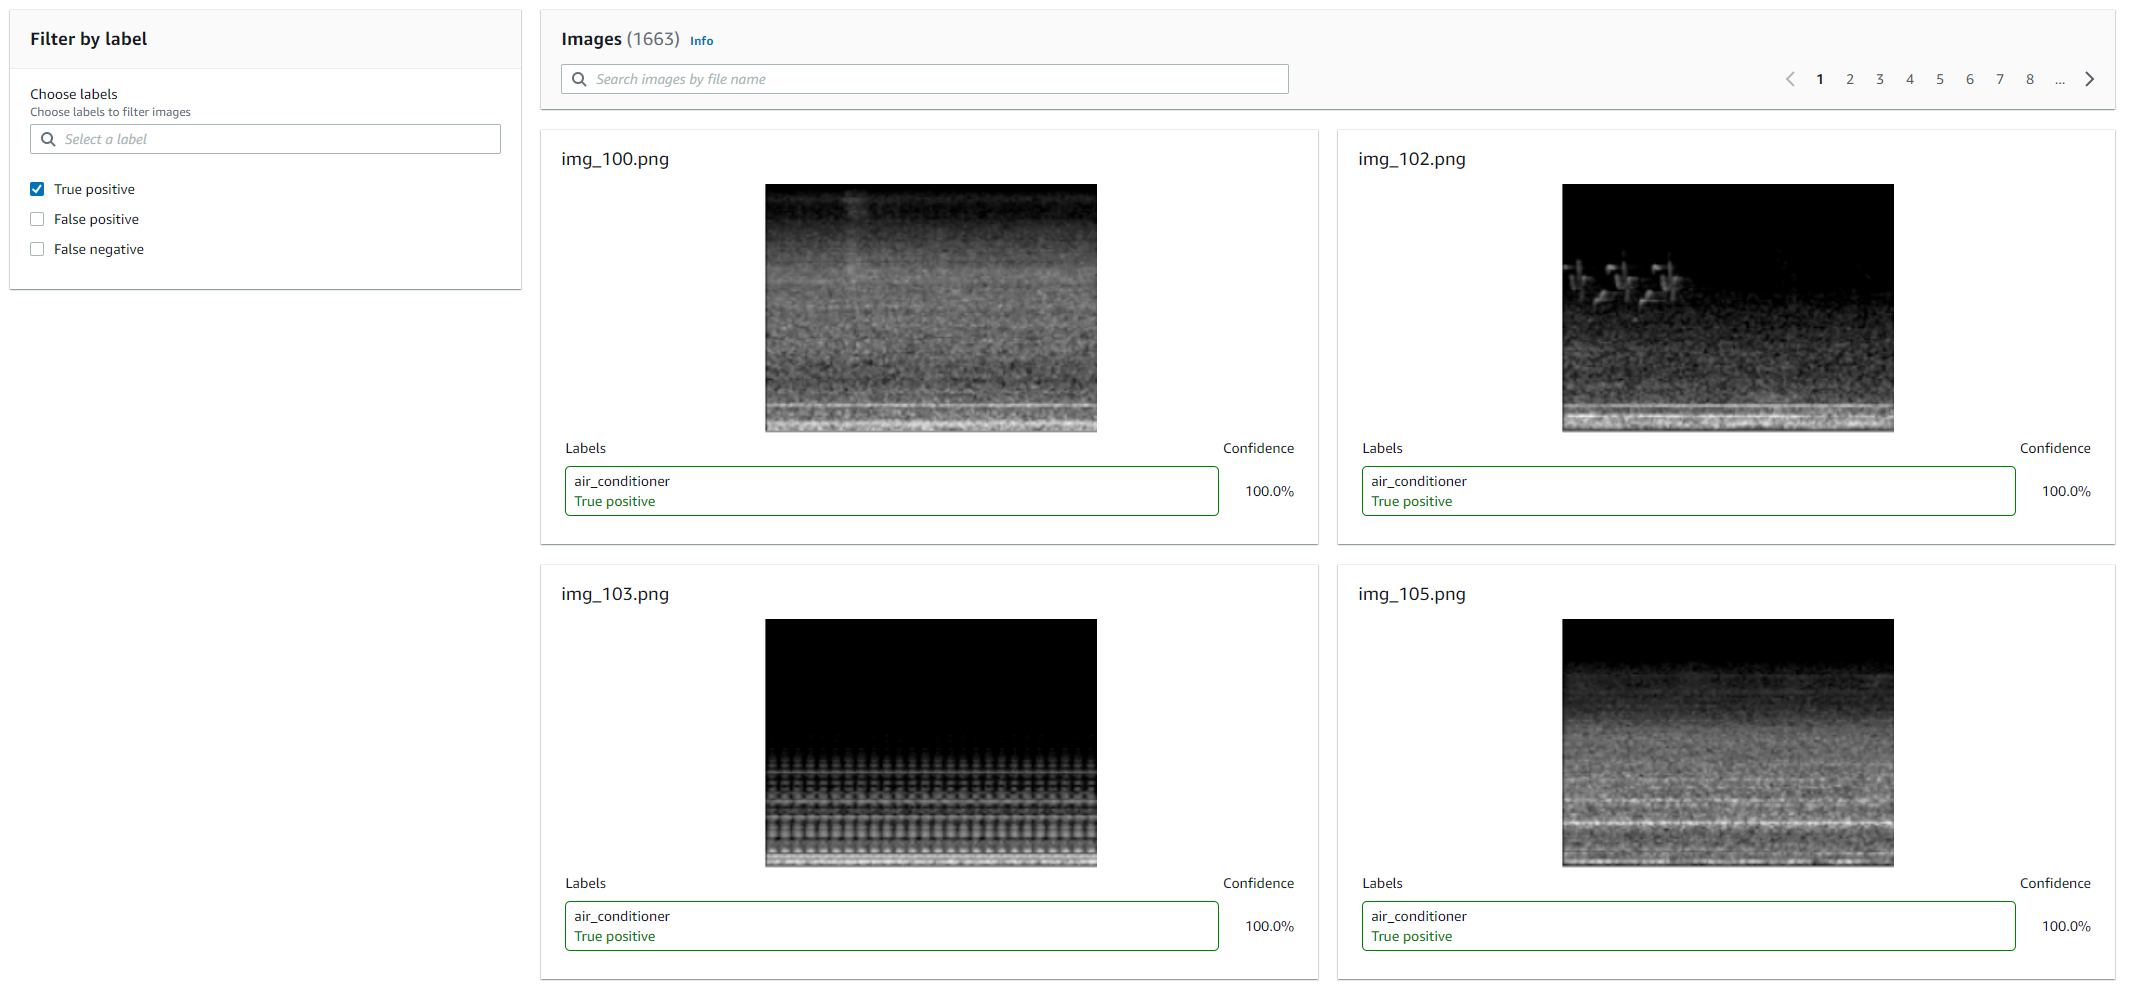

* The False Positive image number of our model is only **48** images
* Also there is **0 False negative image** in our model

 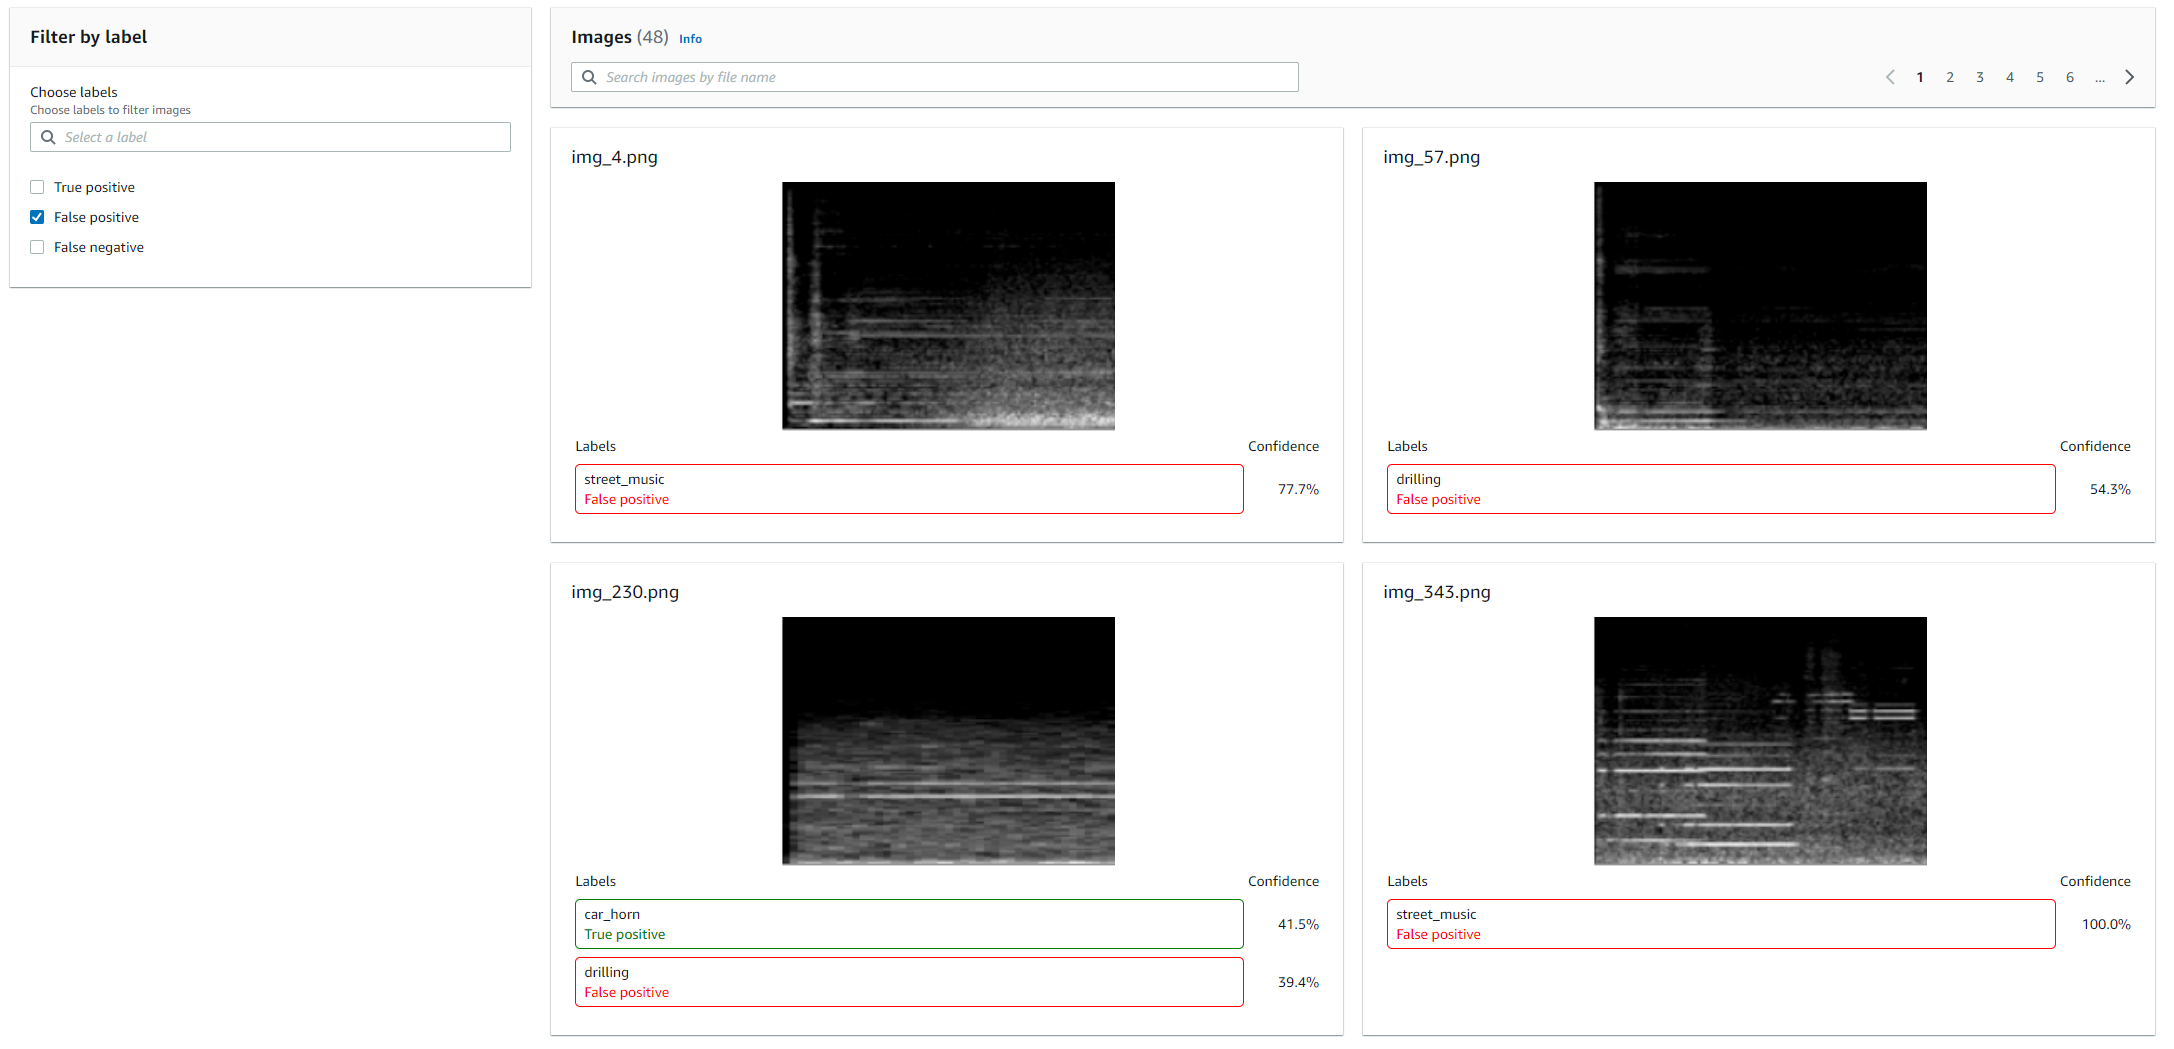

Our validation results are also added as json files under github page.
* Manifest_summary
* Testing_manifest_with_validation
* Training_manifest_with_validation

 ## Hyper Parameter Optimization
 There are different approaches for Hyper Parameter optimization as follows.
* Grid search
* Random search
* Bayesian optimization
* Gradient-based optimization
* evolutionary optimization
* population-based
* Early stopping-based

We had to proceed at the level of the direction Amazon offered us in this regard. As stated in the Developer Guide, Amazon offered us the MinConfidence parameter in case we were not satisfied with the model results. We need to set this between 0-100 in the file that we provide in the API, both when using our model and training it.

* To increase the precision of your model, set a higher value for MinConfidence. For more information, see Reducing false positives (better precision).

* To increase the recall of your model, use a lower value for MinConfidence. For more information, see Reducing false negatives (better recall).

In [ ]:
import boto3
import io
import logging
import argparse
from PIL import Image, ImageDraw, ImageFont

from botocore.exceptions import ClientError

logger = logging.getLogger(__name__)

In [ ]:
def analyze_local_image(rek_client, model, photo, min_confidence):
    """
    Analyzes an image stored as a local file.
    :param rek_client: The Amazon Rekognition Boto3 client.
    :param s3_connection: The Amazon S3 Boto3 S3 connection object.
    :param model: The ARN of the Amazon Rekognition Custom Labels model that you want to use.
    :param photo: The name and file path of the photo that you want to analyze.
    :param min_confidence: The desired threshold/confidence for the call.
    """

    try:
        logger.info ("Analyzing local file: %s", photo)
        image=Image.open(photo) 
        image_type=Image.MIME[image.format]

        if (image_type == "image/jpeg" or image_type== "image/png") == False:
            logger.error("Invalid image type for %s", photo)
            raise ValueError(
                f"Invalid file format. Supply a jpeg or png format file: {photo}"
            )
            
        # get images bytes for call to detect_anomalies
        image_bytes = io.BytesIO()
        image.save(image_bytes, format=image.format)
        image_bytes = image_bytes.getvalue()

        response = rek_client.detect_custom_labels(Image={'Bytes': image_bytes},
            MinConfidence=min_confidence,
            ProjectVersionArn=model)

        show_image (image, response)
        return len(response['CustomLabels'])

    except ClientError as client_err:
        logger.error(format(client_err))
        raise
    except FileNotFoundError as file_error:
        logger.error(format (file_error))
        raise
    

def analyze_s3_image(rek_client,s3_connection, model,bucket,photo, min_confidence):
    """
    Analyzes an image stored in the specified S3 bucket.
    :param rek_client: The Amazon Rekognition Boto3 client.
    :param s3_connection: The Amazon S3 Boto3 S3 connection object.
    :param model: The ARN of the Amazon Rekognition Custom Labels model that you want to use.
    :param bucket: The name of the S3 bucket that contains the image that you want to analyze.
    :param photo: The name of the photo that you want to analyze.
    :param min_confidence: The desired threshold/confidence for the call.
    """

    try:
        #Get image from S3 bucket.
        
        logger.info("analyzing bucket: %s image: %s", bucket, photo)
        s3_object = s3_connection.Object(bucket,photo)
        s3_response = s3_object.get()
        

        stream = io.BytesIO(s3_response['Body'].read())
        image=Image.open(stream)

        image_type=Image.MIME[image.format]

        if (image_type == "image/jpeg" or image_type== "image/png") == False:
            logger.error("Invalid image type for %s", photo)
            raise ValueError(
                f"Invalid file format. Supply a jpeg or png format file: {photo}")
                

        img_width, img_height = image.size  
        draw = ImageDraw.Draw(image)  
        
        #Call DetectCustomLabels 
        response = rek_client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
            MinConfidence=min_confidence,
            ProjectVersionArn=model)

        show_image (image, response)
        return len(response['CustomLabels'])

    except ClientError as err:
        logger.error(format(err))
        raise

def show_image(image, response):
    """
    Displays the analyzed image and overlays analysis results
    :param image: The analyzed image
    :param response: the response from DetectCustomLabels
    """
    try: 
        font_size=40
        line_width=5

        img_width, img_height = image.size  
        draw = ImageDraw.Draw(image)  
                
        # calculate and display bounding boxes for each detected custom label       
        image_level_label_height = 0
        
        for custom_label in response['CustomLabels']:
            confidence=int(round(custom_label['Confidence'],0))
            label_text=f"{custom_label['Name']}:{confidence}%"
            fnt = ImageFont.truetype('Tahoma.ttf', font_size)
            text_width, text_height = draw.textsize(label_text,fnt)

            logger.info(f"Label: {custom_label['Name']}") 
            logger.info(f"Confidence:  {confidence}%")

            # Draw bounding boxes, if present
            if 'Geometry' in custom_label:
                box = custom_label['Geometry']['BoundingBox']
                left = img_width * box['Left']
                top = img_height * box['Top']
                width = img_width * box['Width']
                height = img_height * box['Height']
                
                logger.info("Bounding box")
                logger.info("\tLeft: {0:.0f}".format(left))
                logger.info("\tTop: {0:.0f}".format(top))
                logger.info("\tLabel Width: {0:.0f}".format(width))
                logger.info("\tLabel Height: {0:.0f}".format(height))
                
                points = (
                    (left,top),
                    (left + width, top),
                    (left + width, top + height),
                    (left , top + height),
                    (left, top))
                #Draw bounding box and label text
                draw.line(points, fill="limegreen", width=line_width)
                draw.rectangle([(left + line_width , top+line_width), (left + text_width + line_width, top + line_width + text_height)],fill="black")
                draw.text((left + line_width ,top +line_width), label_text, fill="limegreen", font=fnt) 
            
            #draw image-level label text.
            else:
                draw.rectangle([(10 , image_level_label_height), (text_width + 10, image_level_label_height+text_height)],fill="black")
                draw.text((10,image_level_label_height), label_text, fill="limegreen", font=fnt)  

                image_level_label_height += text_height
            
        image.show()

    except Exception as err:
        logger.error(format(err))
        raise
        
def add_arguments(parser):
    """
    Adds command line arguments to the parser.
    :param parser: The command line parser.
    """


    parser.add_argument(
        "model_arn", help="The ARN of the model that you want to use."
    )

    parser.add_argument(
        "image", help="The path and file name of the image that you want to analyze"
    )
    parser.add_argument(
        "--bucket",  help="The bucket that contains the image. If not supplied, image is assumed to be a local file.", required=False
    )

In [ ]:
def main():

    try:
        logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

        #get command line arguments
        parser = argparse.ArgumentParser(usage=argparse.SUPPRESS)
        add_arguments(parser)
        args = parser.parse_args()
        
        label_count=0
        min_confidence=50

        rek_client=boto3.client('rekognition')
        
        if args.bucket==None:
            # Analyze local image
            label_count=analyze_local_image(rek_client,
                args.model_arn,
                args.image,
                min_confidence)
        else:
            #Analyze image in S3 bucket
            s3_connection = boto3.resource('s3')
            label_count=analyze_s3_image(rek_client,
                s3_connection,
                args.model_arn,
                args.bucket,
                args.image,
                min_confidence)


        print(f"Custom labels detected: {label_count}")

    except ClientError as client_err:
        print("A service client error occurred: " + format(client_err.response["Error"]["Message"]))

    except ValueError as value_err:
        print ("A value error occurred: " + format(value_err))
    
    except FileNotFoundError as file_error:
        print("File not found error: " + format (file_error))

    except Exception as err:
        print("An error occurred: " + format(err))


if __name__ == "__main__":
    main()

## Operation request

The following example JSON request shows the image loaded from an Amazon S3 bucket.

In [ ]:
{
    "ProjectVersionArn": "string", 
     "Image":{ 
        "S3Object":{
            "Bucket":"string",
            "Name":"string",
            "Version":"string"
         }
    },
    "MinConfidence": 90,
    "MaxLabels": 10,
}

#RESULT

The added codes were run over the Cloud-9 service via the AWS CLI. We did not install aws cli on colab. 

Therefore, the images of the outputs are shared on this page.

**Image analysis can be done with a confidence rate of over 0.9 and detection can be made on the images added by deploying on the server at any time.**